In [1]:
# %pip install scikit-learn tifffile numpy matplotlib scikit-image

In [2]:
import numpy as np
import tifffile as tiff
from skimage.registration import optical_flow_ilk, optical_flow_tvl1, phase_cross_correlation
from skimage.transform import warp
import matplotlib.pyplot as plt

# Motion correction in calcium imaging

This is a critical step designed to address the problem of movement artifacts in the imaging data. These movements can be due to several factors like the motion of the animal or organism being studied, the heartbeat, breathing, or even slight movements of the imaging equipment itself. Inaccurate motion correction can lead to false interpretations of neural activity. Here are the underlying processing steps typically involved in motion correction:

1. **Image Registration**:
   - The process often starts with image registration, which involves aligning and overlaying images to a reference frame or template. This template can be a selected frame from the movie or an averaged image from a set of frames.

2. **Identification of Movement**:
   - The algorithm analyzes each frame of the movie in relation to the reference frame to detect movements. This can involve calculating the difference between the current frame and the reference frame.

3. **Calculation of Motion Vectors**:
   - Motion vectors are calculated for each frame (or segments of each frame in the case of non-rigid motion correction). These vectors represent the direction and magnitude of movement needed to align each frame or segment back to the reference position.

4. **Transformation and Alignment**:
   - Using the calculated motion vectors, each frame of the movie is transformed (translated, rotated, or warped) to align with the reference frame. This might involve interpolation to estimate pixel values for the transformed images.

5. **Non-Rigid Correction**:
   - For non-rigid motion correction (like the NoRMCorre algorithm), the image is divided into overlapping patches. Each patch is independently aligned to correct for local movements, allowing different parts of the image to move independently.

6. **Subpixel Accuracy**:
   - Motion correction often involves subpixel shifts to achieve high accuracy. This requires interpolation techniques to estimate the new pixel values after subpixel shifts.

7. **Creation of a Smooth Motion Field**:
   - In advanced methods like NoRMCorre, the motion vectors for each patch are used to infer a smooth motion field across the entire field of view for each frame. This approach ensures a more natural and consistent correction across the image.

8. **Application to Data**:
   - The final step involves applying the calculated transformations to the original movie, resulting in a set of frames where motion artifacts have been corrected.

9. **Quality Assessment**:
   - After motion correction, it's common to assess the quality of the correction, often by checking the stability of the corrected images, or by measuring the similarity between frames post-correction.

The output of motion correction is a stabilized movie where artifacts due to movement have been minimized, allowing for more accurate subsequent analysis, such as neuron segmentation and activity extraction. This process is crucial for ensuring that changes observed in the calcium signals are due to actual neural activity and not due to motion artifacts.

In this notebook, we will see how step 1 through step 3 looks like with a simple dataset!

In [3]:
# Reading frames
# Frame 1: Reference image
# Frame 2: shifted right by 5 pixels
# Frame 3: Shifted down by 5 pixels

with tiff.TiffFile('../data/example_frames_registration.tif') as tif:
    frames = [page.asarray() for page in tif.pages]

In [4]:
# How many frames are there?
len(frames)

3

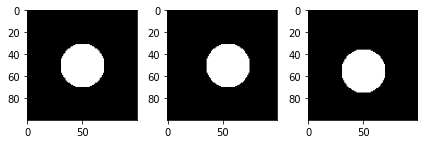

In [5]:
# Plot them all side-by-side (notice the position of white circle in different frames)

plt.subplot(1,3,1)
plt.imshow(frames[0], cmap='gray')

plt.subplot(1,3,2)
plt.imshow(frames[1], cmap='gray')

plt.subplot(1,3,3)
plt.imshow(frames[2], cmap='gray')

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


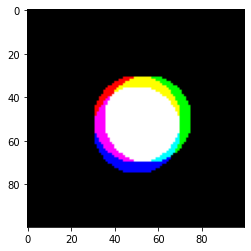

In [6]:
# Plot in another way: all together in RGB

nr, nc = frames[0].shape

seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = frames[0]
seq_im[..., 1] = frames[1]
seq_im[..., 2] = frames[2]

plt.imshow(seq_im)

## Optical Flow Registration: Iterative Lukas-Kanade algorithm (iLK)


The Iterative Lukas-Kanade (iLK) algorithm in optical flow registration estimates the apparent motion of objects between two consecutive frames based on their brightness patterns. It iteratively refines the flow vectors (motion) at each pixel, assuming that the flow is essentially constant in a local neighborhood. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


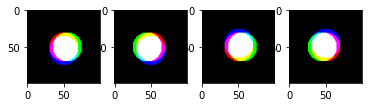

In [7]:
# Step 1: Image Registration
v1, u1 = optical_flow_ilk(frames[0], frames[1])
v2, u2 = optical_flow_ilk(frames[0], frames[2])

# Step 2: Calculation of Motion Vectors
nr, nc = frames[0].shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

# Step 3: Transformation and Alignment
frame_1_warp = warp(frames[0], np.array([row_coords + v1, col_coords + u1]),
                   mode='edge')
frame_2_warp = warp(frames[0], np.array([row_coords + v2, col_coords + u2]),
                   mode='edge')

# Original frame (Frame 0)
ref_im = np.zeros((nr, nc, 3))
ref_im[..., 0] = frames[0] # Reference in Red
ref_im[..., 1] = frames[1] # Frame 1 in Green
ref_im[..., 2] = frames[2] # Frame 2 in Blue

# Frame 1
reg_im_1 = np.zeros((nr, nc, 3))
reg_im_1[..., 0] = frames[0]    # Reference in Red
reg_im_1[..., 1] = frame_1_warp # Registered Frame 1 in Green
reg_im_1[..., 2] = frames[2]    # Frame 2 in Blue

# Frame 2
reg_im_2 = np.zeros((nr, nc, 3))
reg_im_2[..., 0] = frames[0]    # Reference in Red
reg_im_2[..., 1] = frames[1]    # Frame 1 in Green
reg_im_2[..., 2] = frame_2_warp # Registered Frame 2 in Blue

# All registered
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = frames[0]      # Reference in Red
reg_im[..., 1] = frame_1_warp   # Registered Frame 1 in Green
reg_im[..., 2] = frame_2_warp   # Registered Frame 2 in Blue


plt.subplot(1,4,1)
plt.imshow(ref_im)

plt.subplot(1,4,2)
plt.imshow(reg_im_1)

plt.subplot(1,4,3)
plt.imshow(reg_im_2)

plt.subplot(1,4,4)
plt.imshow(reg_im);

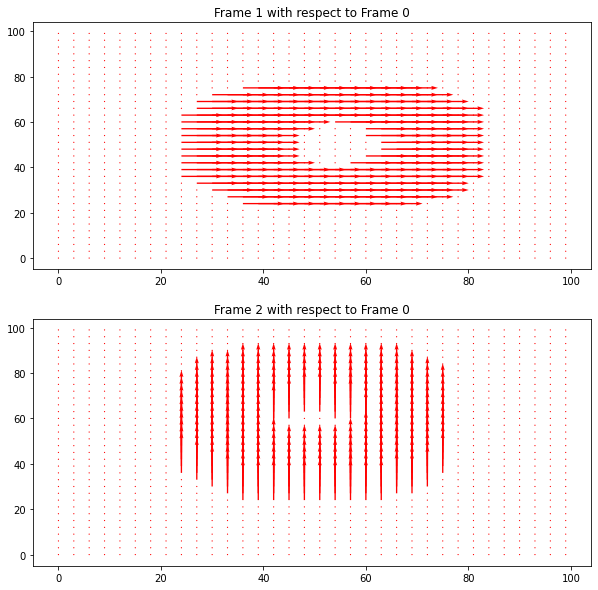

In [8]:
# Quiver Plot

nvec = 30  # Number of vectors to be displayed along each image dimension
nl, nc = frames[0].shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u1_ = u1[::step, ::step]
v1_ = v1[::step, ::step]
u2_ = u2[::step, ::step]
v2_ = v2[::step, ::step]


fig = plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.title("Frame 1 with respect to Frame 0")
plt.quiver(x, y, u1_, v1_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)

plt.subplot(2,1,2)
plt.title("Frame 2 with respect to Frame 0")
plt.quiver(x, y, u2_, v2_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3);


# Unanswered question: The direction of the arrow points to the direction of shift of 
# frame with respect to the reference frame. In the first figure, we do see this. The arrow 
# shows movement towards right (which is correct as the frame is shifted towards right by 5 pixels)
# The second plot does not show this. It seems to indicate upwards motion whereas the frame is
# actually shifted downwards by 5 pixels (To Be Reassessed)

## Optical Flow Registration: TV-L1


The TV-L1 optical flow registration algorithm uses a variational approach that minimizes the total variation (TV) norm of the flow field, combined with an L1 norm measuring the difference in image intensities. This method is robust to noise and illumination changes, making it effective for estimating the dense motion field between two image frames, especially in situations with large displacements or complex motion patterns.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


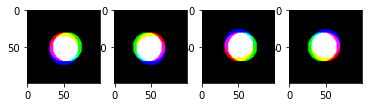

In [9]:
# Step 1: Image Registration
v1, u1 = optical_flow_tvl1(frames[0], frames[1])
v2, u2 = optical_flow_tvl1(frames[0], frames[2])

# Step 2: Calculation of Motion Vectors
nr, nc = frames[0].shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

# Step 3: Transformation and Alignment
frame_1_warp = warp(frames[0], np.array([row_coords + v1, col_coords + u1]),
                   mode='edge')
frame_2_warp = warp(frames[0], np.array([row_coords + v2, col_coords + u2]),
                   mode='edge')

# Original frame (Frame 0)
ref_im = np.zeros((nr, nc, 3))
ref_im[..., 0] = frames[0] # Reference in Red
ref_im[..., 1] = frames[1] # Frame 1 in Green
ref_im[..., 2] = frames[2] # Frame 2 in Blue

# Frame 1
reg_im_1 = np.zeros((nr, nc, 3))
reg_im_1[..., 0] = frames[0]    # Reference in Red
reg_im_1[..., 1] = frame_1_warp # Registered Frame 1 in Green
reg_im_1[..., 2] = frames[2]    # Frame 2 in Blue

# Frame 2
reg_im_2 = np.zeros((nr, nc, 3))
reg_im_2[..., 0] = frames[0]    # Reference in Red
reg_im_2[..., 1] = frames[1]    # Frame 1 in Green
reg_im_2[..., 2] = frame_2_warp # Registered Frame 2 in Blue

# All registered
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = frames[0]      # Reference in Red
reg_im[..., 1] = frame_1_warp   # Registered Frame 1 in Green
reg_im[..., 2] = frame_2_warp   # Registered Frame 2 in Blue


plt.subplot(1,4,1)
plt.imshow(ref_im)

plt.subplot(1,4,2)
plt.imshow(reg_im_1)

plt.subplot(1,4,3)
plt.imshow(reg_im_2)

plt.subplot(1,4,4)
plt.imshow(reg_im);

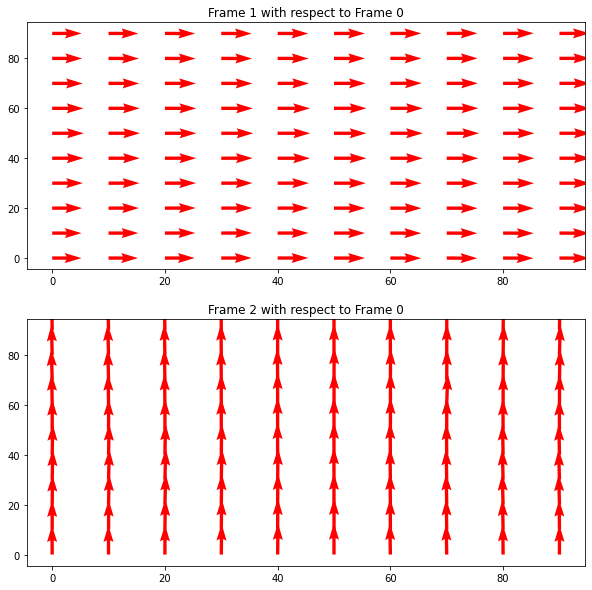

In [10]:
# Quiver Plot

nvec = 10  # Number of vectors to be displayed along each image dimension
nl, nc = frames[0].shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u1_ = u1[::step, ::step]
v1_ = v1[::step, ::step]
u2_ = u2[::step, ::step]
v2_ = v2[::step, ::step]


fig = plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.title("Frame 1 with respect to Frame 0")
plt.quiver(x, y, u1_, v1_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)

plt.subplot(2,1,2)
plt.title("Frame 2 with respect to Frame 0")
plt.quiver(x, y, u2_, v2_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3);


# Unanswered question: The direction of the arrow points to the direction of shift of 
# frame with respect to the reference frame. In the first figure, we do see this. The arrow 
# shows movement towards right (which is correct as the frame is shifted towards right by 5 pixels)
# The second plot does not show this. It seems to indicate upwards motion whereas the frame is
# actually shifted downwards by 5 pixels (To Be Reassessed)

## Phase Cross Correlation: Gave best result for the test data


Phase Cross Correlation estimates the relative shift between two images. It operates in the frequency domain to identify how much one image needs to be translated to align with the other.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


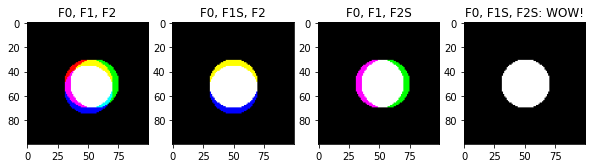

In [11]:
# Step 1: Image Registration
# Step 2: Calculation of Motion Vectors
shift1, _, _ = phase_cross_correlation(frames[0], frames[1])
shift2, _, _ = phase_cross_correlation(frames[0], frames[2])

# Step 3: Transformation and Alignment
frame_1_warp = np.roll(frames[1], shift=(int(shift1[0]), int(shift1[1])), axis=(0, 1))
frame_2_warp = np.roll(frames[2], shift=(int(shift2[0]), int(shift2[1])), axis=(0, 1))

# Original frame (Frame 0)
ref_im = np.zeros((nr, nc, 3))
ref_im[..., 0] = frames[0] # Reference in Red
ref_im[..., 1] = frames[1] # Frame 1 in Green
ref_im[..., 2] = frames[2] # Frame 2 in Blue

# Frame 1
reg_im_1 = np.zeros((nr, nc, 3))
reg_im_1[..., 0] = frames[0]    # Reference in Red
reg_im_1[..., 1] = frame_1_warp # Registered Frame 1 in Green
reg_im_1[..., 2] = frames[2]    # Frame 2 in Blue

# Frame 2
reg_im_2 = np.zeros((nr, nc, 3))
reg_im_2[..., 0] = frames[0]    # Reference in Red
reg_im_2[..., 1] = frames[1]    # Frame 1 in Green
reg_im_2[..., 2] = frame_2_warp # Registered Frame 2 in Blue

# All registered
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = frames[0]      # Reference in Red
reg_im[..., 1] = frame_1_warp   # Registered Frame 1 in Green
reg_im[..., 2] = frame_2_warp   # Registered Frame 2 in Blue



fig = plt.figure(figsize=(10,10))

plt.subplot(1,4,1)
plt.title("F0, F1, F2")
plt.imshow(ref_im)

plt.subplot(1,4,2)
plt.title("F0, F1S, F2")
plt.imshow(reg_im_1)

plt.subplot(1,4,3)
plt.title("F0, F1, F2S")
plt.imshow(reg_im_2)

plt.subplot(1,4,4)
plt.title("F0, F1S, F2S: WOW!")
plt.imshow(reg_im);



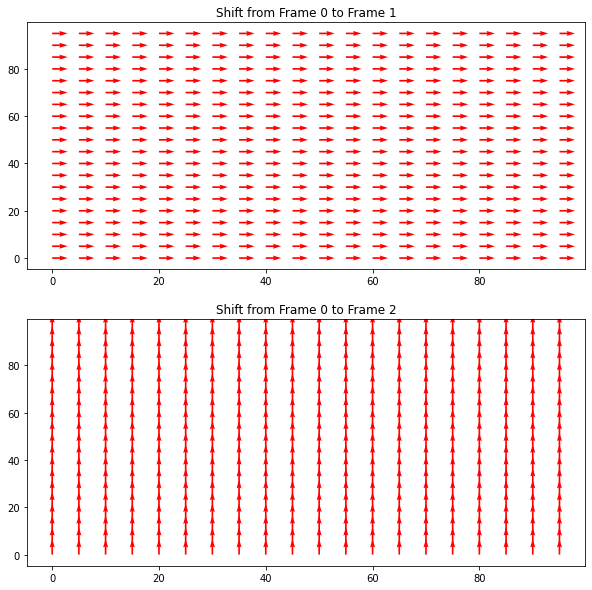

In [12]:
nvec = 20
nl, nc = frames[0].shape
step = max(nl // nvec, nc // nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u1_ = np.full_like(x, -shift1[1])  # Negative sign for correct direction
v1_ = np.full_like(y, -shift1[0])
u2_ = np.full_like(x, -shift2[1])
v2_ = np.full_like(y, -shift2[0])

fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title("Shift from Frame 0 to Frame 1")
plt.quiver(x, y, u1_, v1_, color='r', units='dots', angles='xy', scale_units='xy', lw=3)

plt.subplot(2, 1, 2)
plt.title("Shift from Frame 0 to Frame 2")
plt.quiver(x, y, u2_, v2_, color='r', units='dots', angles='xy', scale_units='xy', lw=3)


# Maybe I am plotting it wrong. The arrows show incorrect directions but the registered image is perfect